In [7]:
import math
import torch
import gpytorch
from torch import optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable
from matplotlib import pyplot as plt
import csv

In [ ]:
# Simple training data: let's try to learn a sine function, but with KISS-GP let's use 100 training examples.
def make_data(cuda=False):
    train_x = Variable(torch.linspace(0, 1, 500))
    train_y = Variable(torch.sin(train_x.data * (2 * math.pi)))
    test_x = Variable(torch.linspace(0, 1, 100))
    test_y = Variable(torch.sin(test_x.data * (2 * math.pi)))
    if cuda:
        train_x = train_x.cuda()
        train_y = train_y.cuda()
        test_x = test_x.cuda()
        test_y = test_y.cuda()
    return train_x, train_y, test_x, test_y

In [ ]:
def distance(uid1, vid1, uid2, vid2):
    user1 = user_feature[uid1]
    user2 = user_feature[uid2]
    movie1 = movie_feature[vid1]
    movie2 = movie_feature[vid2]
    sum = 0
    for i in range(0, 28):
        if user1[i] != user2[i]:
            sum += 1
    for i in range(0, 19):
        if movie1[i] != movie2[i]:
            sum += 1
    
    return sum

def build_sparse_W(pattern = 'train'):
#Create sparse matrix self.W based on:
#1.self.indexed_training_set or self.indexed_testing_set
    #2.self.indexed_inducing_set
    #call choose_inducing_point before calling this method
    if pattern == 'train':
        X = indexed_training_set
    elif pattern == 'test':
        X = indexed_testing_set
    U = indexed_inducing_set
    n = len(X)
    m = len(U)
    W = np.matrix(np.zeros([n,m]))
    for i in range(n):
        low_1,low_2,index_1,index_2 = [47,47,-1,-1]
        for j in range(m):
            ui,uj = X[i][0],U[j][0]
            vi,vj = X[i][1],U[j][1]
            buffer = distance(ui, vi, uj, vj)
            if buffer <= low_1:
                low_2 = low_1
                low_1 = buffer
                index_2 = index_1
                index_1 = j
                if low_1 == 0 and low_2 == 0:
                    break
        if low_1 == low_2:
            W[i,[index_1,index_2]] = 0.5
        else:
            W[i,[index_1,index_2]] = np.array([low_2,low_1])/(low_2 + low_1)
    if pattern == 'train':
        training_W = W
    elif pattern == 'test':
        testing_W = W
    return W

In [82]:
def choose_inducing_point(ratio,pattern = 'random',source = 'training set'):
    # function used to choose inducing point from self.training_set
    # ratio: inducing_point/data_size
    # Extra choosing method could be changed by pattern
    if pattern == 'random' and source == 'training set':
        n = train_reduced.shape[0]
        m = np.ceil(n*ratio).astype(int)
        indexed_inducing_set = train_reduced[np.random.choice(n,m,replace = False)]
    return indexed_inducing_set

def build_Kuu(a1,b1,a2,b2):
    m = indexed_inducing_set.shape[0]
    Kuu = np.zeros((m,m), dtype = np.int)
    for i in range(0,m):
        uid1 = indexed_inducing_set[i][0]
        vid1 = indexed_inducing_set[i][1]
        user1 = user_feature[uid1]
        movie1 = movie_feature[vid1]
        for j in range(i,m):
            uid2 = indexed_inducing_set[j][0]
            vid2 = indexed_inducing_set[j][1]
            user2 = user_feature[uid2]
            movie2 = movie_feature[vid2]
            k_side_user = np.dot(np.reshape(user1,(1, 28)), np.reshape(user2,(28,1)))
            k_side_movie = np.dot(np.reshape(movie1,(1, 19)), np.reshape(movie2,(19,1)))
            k_user = 0
            k_movie = 0
            
            if uid1 == uid2:
                k_user += a1 * a1
            k_user += b1 * b1 * k_side_user
            
            if vid1 == vid2:
                k_movie += a2 * a2
            k_movie += b2 * b2 * k_side_movie
            
            Kuu[i][j] = np.dot(k_user, k_movie)
            Kuu[j][i] = Kuu[i][j]
            
    return Kuu

In [ ]:
'''inducePointLocation: (uid,vid) m by 2
w is the weight matrix n by m
sigma_squared: noise
y : n by 1
return value: (K+Sig^2I)^-1*y
'''
user_feature = np.loadtxt("user_feature.csv", dtype = int)
movie_feature = np.loadtxt("movie_feature.csv", dtype = int)
def woodbury_inversion(inducePointLocation):
    w = build_sparse_W()
    def hyper(x, w, y):
        a1 = x[0]
        b1 = x[1]
        a2 = x[2]
        b2 = x[3]
        sigma_squared = x[4]
        kuu = build_Kuu(a1,b1,a2,b2)
        inv_kuu = np.linalg.inv(kuu)
        b = np.linalg.inv(inv_kuu + 1 / sigma_squared * w.transpose() * w)
        a = 1 / sigma_squared * w
        n = np.size(a,0)
        m = np.size(b,1)
        temp_res = np.zeros((,n), dtype = np.int)
        for i in range(0, n):
            res = np.zeros((n,), dtype = np.int)
            prod = np.zeros((m,), dtype = np.int)
            for j in range(0, m):
                prod[j] = a[i] * b[:,j]
            for k in range(0, n):
                res[k] = prod * a[k, :].transpose()
            temp_res[i] = res * y
        
        return (y / sigma_squared - temp_res)
    return hyper

In [ ]:
class ProductKernel(Kernel):
    def __init__(self, a1_bound=(0, 10), a2_bound=(0, 10), eps=1e-5):
        super(ProductKernel, self).__init__()
        self.eps = eps
        self.register_parameter('a1', nn.Parameter(torch.zeros(1, 1)), a1_bound)
        self.register_parameter('a2', nn.Parameter(torch.zeros(1, 1)), a2_bound)
#         self.register_parameter('a1', nn.Parameter(torch.zeros(1, 1)), a1__bound)
#         self.register_parameter('a1', nn.Parameter(torch.zeros(1, 1)), a1__bound)

    def forward(self, x1, x2):
        n, d = x1.size()
        m, _ = x2.size()

        
        res = 2 * x1.matmul(x2.transpose(0, 1))

        x1_squared = torch.bmm(x1.view(n, 1, d), x1.view(n, d, 1))
        x1_squared = x1_squared.view(n, 1).expand(n, m)
        x2_squared = torch.bmm(x2.view(m, 1, d), x2.view(m, d, 1))
        x2_squared = x2_squared.view(1, m).expand(n, m)
        res.sub_(x1_squared).sub_(x2_squared)  # res = -(x - z)^2

        res = res / (self.log_lengthscale.exp() + self.eps)  # res = -(x - z)^2 / lengthscale
        res.exp_()
        return res

In [ ]:
# All tests that pass with the exact kernel should pass with the interpolated kernel.
class LatentFunction(gpytorch.GridInducingPointModule):
    def __init__(self):
        super(LatentFunction, self).__init__(grid_size=100, grid_bounds=[(0,500),(0, 800)])
        self.mean_module = ConstantMean(constant_bounds=[-1e-5, 1e-5])
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred


class GPRegressionModel(gpytorch.GPModel):
    def __init__(self):
        super(GPRegressionModel, self).__init__(GaussianLikelihood())
        self.latent_function = LatentFunction()

    def forward(self, x):
        return self.latent_function(x)

In [ ]:
def test_kissgp_gp_mean_abs_error(train_x, train_y, test_x, test_y):
    gp_model = GPRegressionModel()

    # Optimize the model
    gp_model.train()
    optimizer = optim.Adam(gp_model.parameters(), lr=0.1)
    optimizer.n_iter = 0
    for i in range(10):
        print(i)
        optimizer.zero_grad()
        output = gp_model(train_x)
        loss = -gp_model.marginal_log_likelihood(output, train_y)
        loss.backward()
        optimizer.n_iter += 1
        optimizer.step()

    # Test the model
    gp_model.eval()
    gp_model.condition(train_x, train_y)
    test_preds = gp_model(test_x).mean()
    mean_abs_error = torch.mean(torch.abs(test_y - test_preds))
    print(mean_abs_error.data.squeeze()[0])

#     assert(mean_abs_error.data.squeeze()[0] < 0.05)



In [3]:
import numpy as np
import csv
train_reduced = []
test_reduced = []

training_b = np.loadtxt("ubbase.txt", dtype = int, usecols=(0, 1, 2))
test_b = np.loadtxt("ubtest.txt", dtype = int, usecols=(0, 1, 2))

for i in range(0, training_b.shape[0]):
    if training_b[i][0] <= 500 and training_b[i][1] <= 800:
        train_reduced.append(training_b[i])

for i in range(0, test_b.shape[0]):
    if test_b[i][0] <= 500 and test_b[i][1] <= 800:
        test_reduced.append(test_b[i])

train_reduced = np.asarray(train_reduced)
test_reduced = np.asarray(test_reduced)

print(len(train_reduced))
print(len(test_reduced))

44149
4367


(45, 45)


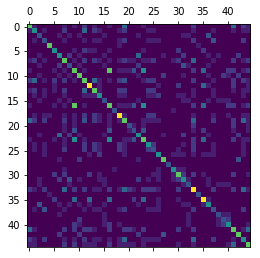

NameError: name 'build_sparse_W' is not defined

In [94]:
import matplotlib.pyplot as plt
global user_feature 
user_feature = []
with open("user_feature.csv") as f:
    csv_file = csv.reader(f)
    for row in csv_file:
        user_feature.append(row)
    user_feature = np.array(user_feature, dtype = np.int)
    
#user_feature = np.loadtxt("user_feature.csv", dtype = np.int)
global movie_feature 
movie_feature = []
with open("movie_feature.csv") as f:
    csv_file = csv.reader(f)
    for row in csv_file:
        movie_feature.append(row)
    movie_feature = np.array(movie_feature, dtype = np.int)
    
global indexed_inducing_set 
indexed_inducing_set = choose_inducing_point(0.001)
K = build_Kuu(0, 5, 0, 2)
np.set_printoptions(threshold=np.nan)
print(K.shape)
plt.matshow(K)
plt.show()
W = build_sparse_W()
print(W.shape)

In [ ]:
def prediction(test_reduced,hyper):
    a1 = hyper[0]
    b1 = hyper[1]
    a2 = hyper[2]
    b2 = hyper[3]
    Kuu = build_Kuu(a1,b1,a2,b2)
    

In [55]:
train_x = torch.from_numpy(train_reduced[:,0:2])
train_x = train_x.float()
train_x = Variable(train_x)

train_y = torch.from_numpy(train_reduced[:,-1])
train_y = train_y.float()
train_y = Variable(train_y)

test_x = torch.from_numpy(test_reduced[:,0:2])
test_x = test_x.float()
test_x = Variable(test_x)

test_y = torch.from_numpy(test_reduced[:,-1])
test_y = test_y.float()
test_y = Variable(test_y)

test_kissgp_gp_mean_abs_error(train_x, train_y, test_x, test_y)

NameError: name 'test_kissgp_gp_mean_abs_error' is not defined

In [40]:
a = np.zeros((5,1))
print(a.shape)
b = np.reshape(a,(1,5))
print(b.shape)

(5, 1)
(1, 5)
